# Chapter 9 (Bonus) — Modern solvers and pedagogical reflection

**A companion chapter to:** J.C.G. Walker, *Numerical Adventures with Geochemical Cycles*, Oxford University Press, 1991.

---

## 9.1 Why this chapter exists

Throughout Chapters 2–8 we have solved every problem with Walker's own tools, which he implemented in `BASIC`: forward Euler, reverse Euler, Newton-Raphson iteration, and Gaussian elimination. These are *deliberately* simple, Walker chose them so that the reader understands every line of the solver, not just the physics.

Modern scientific computing offers far more powerful tools. Python's `scipy.integrate.solve_ivp` provides access to adaptive, high-order methods that are superior in every way: accuracy, stability, efficiency, and robustness. Under the hood, the scipy solvers are written in C++, so you access the full speed that your computer can provide, compared to the much slover interprative steps of writing it all in Python.

So why not just use SciPy from the start? This chapter answers that question by running the same problems with both approaches, side by side. The comparison will make the case that **Walker was right** to build from scratch, and that **you should also learn to use the modern tools** once you understand what they do.

---

## 9.2 What modern solvers (for example `SciPy`) actually do

SciPy's `solve_ivp` offers several methods:

| Method | Order | Type | Adaptive | Best for |
|:---|:---:|:---|:---:|:---|
| `RK45` | 4(5) | Explicit Runge-Kutta | Yes | Non-stiff problems |
| `RK23` | 2(3) | Explicit Runge-Kutta | Yes | Low accuracy needs |
| `Radau` | 5 | Implicit Runge-Kutta | Yes | Stiff problems |
| `BDF` | 1–5 | Implicit multistep | Yes | Stiff problems |
| `LSODA` | varies | Auto-switching | Yes | Unknown stiffness |

Key features that Walker's methods lack:

- **Adaptive step size**: the solver estimates the local error at each step and adjusts $\Delta t$ to keep the error below a tolerance. Walker's fixed-step Euler methods have no error control.

- **High order**: Radau is 5th order — the error scales as $O(\Delta t^5)$. Walker's reverse Euler is 1st order — $O(\Delta t)$. For the same accuracy, Radau can take *much* larger steps.

- **Automatic Jacobian**: Radau and BDF compute (or approximate) the Jacobian internally. You don't need to write it yourself.

But notice: **Radau is doing exactly what Walker taught us**, implicit stepping with Newton iteration, just with higher-order formulas and automatic error control on top.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

np.set_printoptions(precision=6, suppress=True)

---

## 9.3 Test problem: nonlinear CO₂ exchange (Chapter 4)

We revisit the atmosphere-ocean CO₂ exchange with the power-law Revelle factor from Chapter 4. This was the problem that first motivated Walker's Newton-Raphson approach.

In [12]:
# ============================================================
# Chapter 4 system: nonlinear CO₂ exchange
# ============================================================
tau = 8.6           # exchange timescale (yr)
xi = 10.0           # Revelle factor exponent
mu = 0.016          # M_atm / M_ocean

def rhs_co2(t, y):
    """Atmosphere-ocean CO₂ with power-law Revelle factor.
    y = [p, c] — normalised atmospheric pCO₂ and oceanic DIC.
    """
    p, c = y
    dpdt = (c**xi - p) / tau
    dcdt = -mu * (c**xi - p) / tau
    return np.array([dpdt, dcdt])

def jac_co2(t, y):
    """Analytical Jacobian."""
    p, c = y
    return np.array([
        [-1/tau,            xi * c**(xi-1) / tau],
        [mu/tau,           -mu * xi * c**(xi-1) / tau]
    ])

# Initial condition: instantaneous CO₂ doubling
y0_co2 = np.array([2.0, 1.0])  # atmosphere doubled, ocean unchanged
t_span = (0, 500)              # 500 years
t_eval = np.linspace(0, 500, 1000)

In [13]:
# ============================================================
# Walker's reverse Euler + Newton-Raphson (from Chapter 4)
# ============================================================
def reverse_euler_co2(y0, dt, n_steps):
    """Walker's method: reverse Euler + Newton-Raphson."""
    I = np.eye(2)
    y = y0.copy()
    t_vals = [0.0]
    y_vals = [y.copy()]
    total_newton = 0
    
    for n in range(n_steps):
        t_new = (n + 1) * dt
        y_k = y.copy()
        
        for k in range(20):
            f_k = rhs_co2(t_new, y_k)
            g_k = y_k - y - dt * f_k
            if np.max(np.abs(g_k)) < 1e-12:
                total_newton += k + 1
                break
            J_g = I - dt * jac_co2(t_new, y_k)
            y_k = y_k + np.linalg.solve(J_g, -g_k)
        
        y = y_k
        t_vals.append(t_new)
        y_vals.append(y.copy())
    
    return np.array(t_vals), np.array(y_vals), total_newton

In [14]:
# ============================================================
# Comparison: accuracy vs step size
# ============================================================

# "Truth" — SciPy Radau with tight tolerances
sol_ref = solve_ivp(rhs_co2, t_span, y0_co2, method='Radau',
                    jac=jac_co2, rtol=1e-12, atol=1e-14,
                    t_eval=t_eval, dense_output=True)
p_ref_final = sol_ref.y[0, -1]
print(f"Reference solution (Radau, rtol=1e-12):")
print(f"  p(500) = {p_ref_final:.10f}")
print(f"  Function evaluations: {sol_ref.nfev}")
print(f"  Jacobian evaluations: {sol_ref.njev}")

# Scan step sizes for Walker's method
dt_values = [0.5, 1, 2, 5, 10, 20, 50]
walker_errors = []
walker_evals = []

for dt in dt_values:
    n_steps = int(500 / dt)
    t_w, y_w, n_newton = reverse_euler_co2(y0_co2, dt, n_steps)
    err = abs(y_w[-1, 0] - p_ref_final)
    walker_errors.append(err)
    # Each Newton iteration requires 1 function eval + 1 Jacobian eval
    walker_evals.append(n_newton)

# Scan tolerances for SciPy Radau
rtol_values = [1e-3, 1e-5, 1e-7, 1e-9, 1e-11]
scipy_errors = []
scipy_evals = []

for rtol in rtol_values:
    sol = solve_ivp(rhs_co2, t_span, y0_co2, method='Radau',
                    jac=jac_co2, rtol=rtol, atol=rtol*1e-3,
                    dense_output=True)
    p_end = sol.sol(500)[0]
    err = abs(p_end - p_ref_final)
    scipy_errors.append(err)
    scipy_evals.append(sol.nfev)

Reference solution (Radau, rtol=1e-12):
  p(500) = 1.1454540099
  Function evaluations: 7891
  Jacobian evaluations: 1


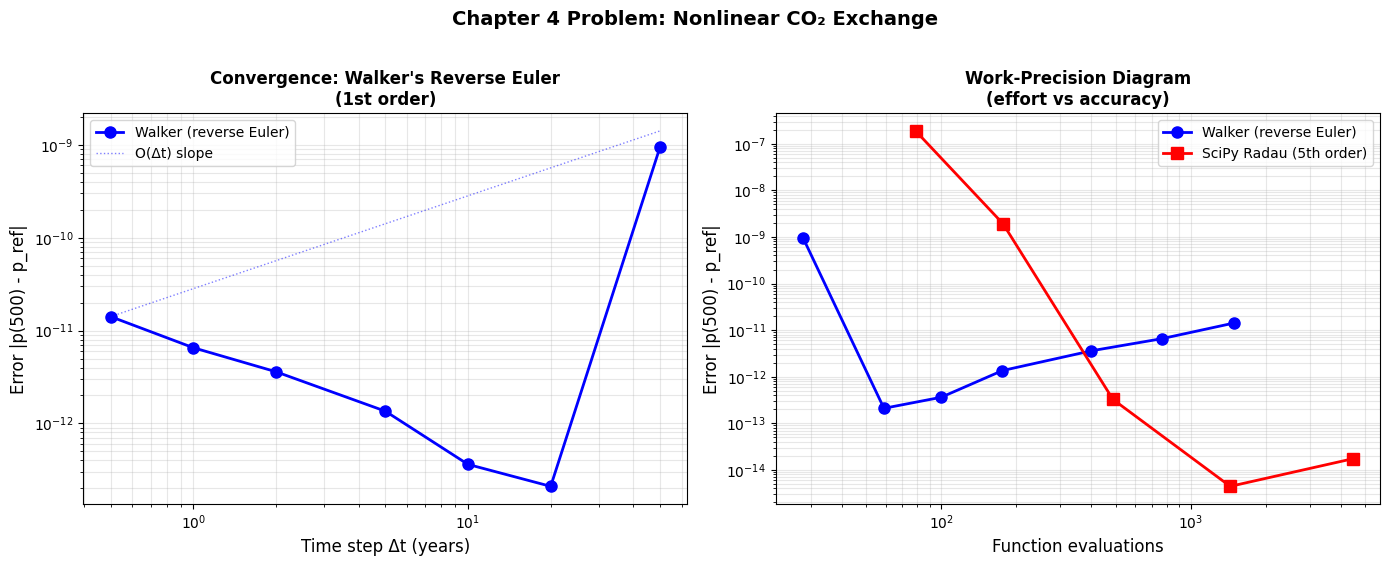

Walker's method (dt=1 yr, 500 steps):
  Error: 6.54e-12, Newton evals: 764

SciPy Radau (rtol=1e-7):
  Error: 3.26e-13, Function evals: 488


In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5.5))

# Error vs step size / tolerance
ax1.loglog(dt_values, walker_errors, 'bo-', linewidth=2, markersize=8,
           label='Walker (reverse Euler)')
# Add reference line for O(dt) convergence
dt_ref = np.array([0.5, 50])
ax1.loglog(dt_ref, walker_errors[0] * dt_ref / dt_ref[0], 'b:',
           linewidth=1, alpha=0.5, label='O(Δt) slope')
ax1.set_xlabel('Time step Δt (years)', fontsize=12)
ax1.set_ylabel('Error |p(500) - p_ref|', fontsize=12)
ax1.set_title('Convergence: Walker\'s Reverse Euler\n(1st order)',
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, which='both')

# Work-precision diagram
ax2.loglog(walker_evals, walker_errors, 'bo-', linewidth=2, markersize=8,
           label='Walker (reverse Euler)')
ax2.loglog(scipy_evals, scipy_errors, 'rs-', linewidth=2, markersize=8,
           label='SciPy Radau (5th order)')
ax2.set_xlabel('Function evaluations', fontsize=12)
ax2.set_ylabel('Error |p(500) - p_ref|', fontsize=12)
ax2.set_title('Work-Precision Diagram\n(effort vs accuracy)',
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')

fig.suptitle('Chapter 4 Problem: Nonlinear CO₂ Exchange',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Walker's method (dt=1 yr, 500 steps):")
idx = dt_values.index(1)
print(f"  Error: {walker_errors[idx]:.2e}, Newton evals: {walker_evals[idx]}")
print(f"\nSciPy Radau (rtol=1e-7):")
idx_s = rtol_values.index(1e-7)
print(f"  Error: {scipy_errors[idx_s]:.2e}, Function evals: {scipy_evals[idx_s]}")

### What the work-precision diagram tells us

For the **same computational effort**, SciPy's Radau method achieves errors that are **many orders of magnitude smaller** than Walker's reverse Euler. This is the payoff of 5th-order accuracy + adaptive stepping.

Conversely, for the **same accuracy**, SciPy needs far fewer function evaluations. This matters when function evaluations are computationally expensive (e.g., the 60×60 system from Chapter 8, or in reality much, much worse for complex systems). From a pure computational standpoint, there is no contest. But read on...

---

## 9.4 What you lose: The Black Box problem

When you call `solve_ivp(..., method='Radau')`, many things happen
invisibly:

- The solver estimates the Jacobian (by finite differences, unless you
  provide it)
- It factors a matrix at each step (like Walker's GAUSS, but for a
  higher-order implicit formula)
- It estimates the local truncation error
- It rejects steps if the error is too large
- It adjusts the step size according to a control algorithm

**None of this is visible to you.** Let us make it visible.

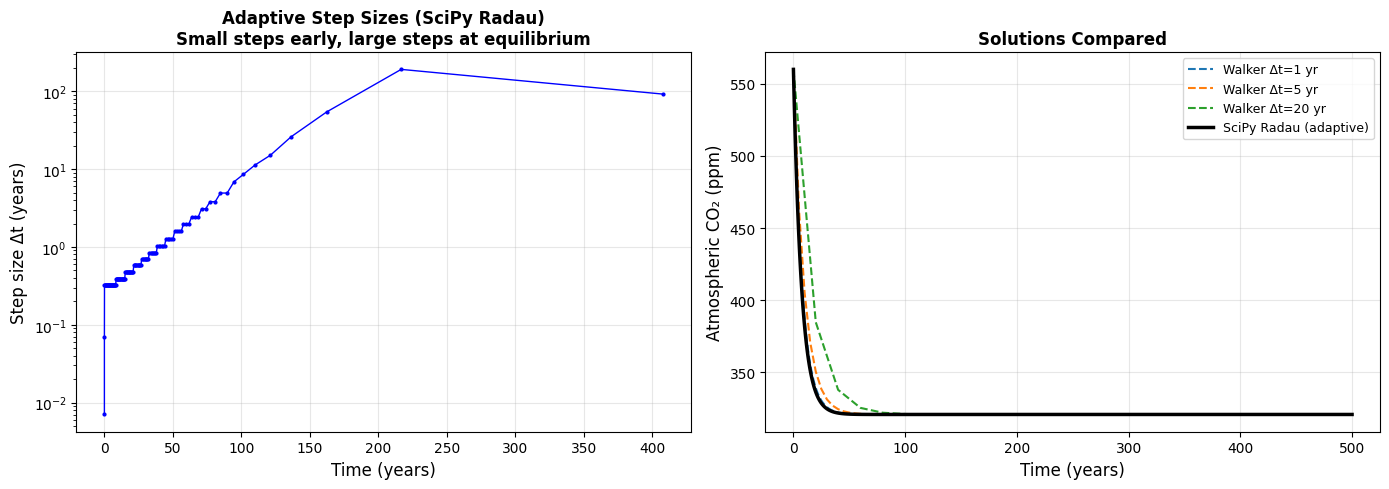

SciPy: 119 steps, min Δt = 0.007 yr, max Δt = 191.2 yr
Walker (Δt=5): 100 steps, constant


In [16]:
# ============================================================
# What SciPy does internally — made visible
# ============================================================

# Solve with Radau, extracting internal diagnostics
sol = solve_ivp(rhs_co2, t_span, y0_co2, method='Radau',
                jac=jac_co2, rtol=1e-8, atol=1e-10,
                dense_output=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Step sizes taken by the adaptive solver
dt_adaptive = np.diff(sol.t)
ax1.semilogy(sol.t[:-1], dt_adaptive, 'b.-', markersize=4, linewidth=1)
ax1.set_xlabel('Time (years)', fontsize=12)
ax1.set_ylabel('Step size Δt (years)', fontsize=12)
ax1.set_title('Adaptive Step Sizes (SciPy Radau)\n'
              'Small steps early, large steps at equilibrium',
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Compare solutions
# Walker with various dt
for dt_w in [1, 5, 20]:
    t_w, y_w, _ = reverse_euler_co2(y0_co2, dt_w, int(500/dt_w))
    ax2.plot(t_w, y_w[:, 0] * 280, '--', linewidth=1.5,
             label=f'Walker Δt={dt_w} yr')

ax2.plot(sol.t, sol.y[0] * 280, 'k-', linewidth=2.5,
         label='SciPy Radau (adaptive)')
ax2.set_xlabel('Time (years)', fontsize=12)
ax2.set_ylabel('Atmospheric CO₂ (ppm)', fontsize=12)
ax2.set_title('Solutions Compared', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"SciPy: {len(sol.t)} steps, min Δt = {min(dt_adaptive):.3f} yr, "
      f"max Δt = {max(dt_adaptive):.1f} yr")
print(f"Walker (Δt=5): {int(500/5)} steps, constant")

The adaptive solver takes **small steps** during the rapid initial transient (when the system is changing fast) and **large steps** once it approaches equilibrium. This is very smart, but it is not transparent, you just get a nice solution without knowing what is going on under the hood.

With Walker's fixed-step method, you *choose* the step size and you *see* whether the Newton iteration converges easily (1–2 iterations) or struggles (4+ iterations). That struggle tells you something about the physics, how nonlinear the system is at that moment.

---

## 9.5 What you gain from Walker's approach

### 1. You understand stability

Walker deliberately shows forward Euler blowing up (Chapter 7: the climate EBM is unstable with Δt > 0.004 yr). With SciPy, you don't see instability, the solver quietly (and smartly) takes tiny steps. But the *physics* of stiffness is still there; you just can't see it.

In [17]:
# Forward Euler instability (Chapter 7 climate model)
# The eigenvalues of the diffusion operator determine the CFL limit.
# Walker's explicit method SHOWS you this; SciPy's implicit method HIDES it.

# Simple diffusion equation: du/dt = D * d²u/dx² on [0,1]
N = 20; dx = 1.0/N
D_test = 1.0

# Diffusion matrix
A = np.zeros((N, N))
for i in range(N):
    A[i, i] = -2
    if i > 0: A[i, i-1] = 1
    if i < N-1: A[i, i+1] = 1
A *= D_test / dx**2

eigenvalues = np.linalg.eigvals(A)
lambda_max = np.max(np.abs(eigenvalues))
dt_cfl = 2.0 / lambda_max

print(f"Diffusion matrix: {N}×{N}")
print(f"Most negative eigenvalue: {np.min(eigenvalues.real):.1f}")
print(f"CFL stability limit: Δt < {dt_cfl:.4f}")
print(f"")
print(f"Forward Euler with Δt = {1.5*dt_cfl:.4f} (1.5× CFL):")

u = np.sin(np.pi * np.linspace(dx/2, 1-dx/2, N))
dt_unstable = 1.5 * dt_cfl
for step in range(5):
    u = u + dt_unstable * A @ u
print(f"  After 5 steps: max|u| = {np.max(np.abs(u)):.1e} — UNSTABLE")

print(f"\nReverse Euler with Δt = {100*dt_cfl:.1f} (100× CFL):")
u = np.sin(np.pi * np.linspace(dx/2, 1-dx/2, N))
I = np.eye(N)
dt_big = 100 * dt_cfl
for step in range(5):
    u = np.linalg.solve(I - dt_big * A, u)
print(f"  After 5 steps: max|u| = {np.max(np.abs(u)):.4f} — Stable")
print(f"\n→ Walker's lesson: implicit methods are unconditionally stable.")
print(f"  SciPy's Radau uses the same principle, but you never see the eigenvalues.")

Diffusion matrix: 20×20
Most negative eigenvalue: -1591.1
CFL stability limit: Δt < 0.0013

Forward Euler with Δt = 0.0019 (1.5× CFL):
  After 5 steps: max|u| = 9.1e-01 — UNSTABLE

Reverse Euler with Δt = 0.1 (100× CFL):
  After 5 steps: max|u| = 0.0225 — Stable

→ Walker's lesson: implicit methods are unconditionally stable.
  SciPy's Radau uses the same principle, but you never see the eigenvalues.


### 2. You see the Jacobian

In Walker's Newton-Raphson, you write the Jacobian explicitly (or compute it by finite differences and *look* at it). The structure of the Jacobian tells you about the physics:

- Tridiagonal → diffusion (nearest-neighbour coupling)
- Block structure → multiple species in each reservoir
- Large off-diagonal entries → strong coupling between reservoirs
- Large diagonal entries → fast local processes

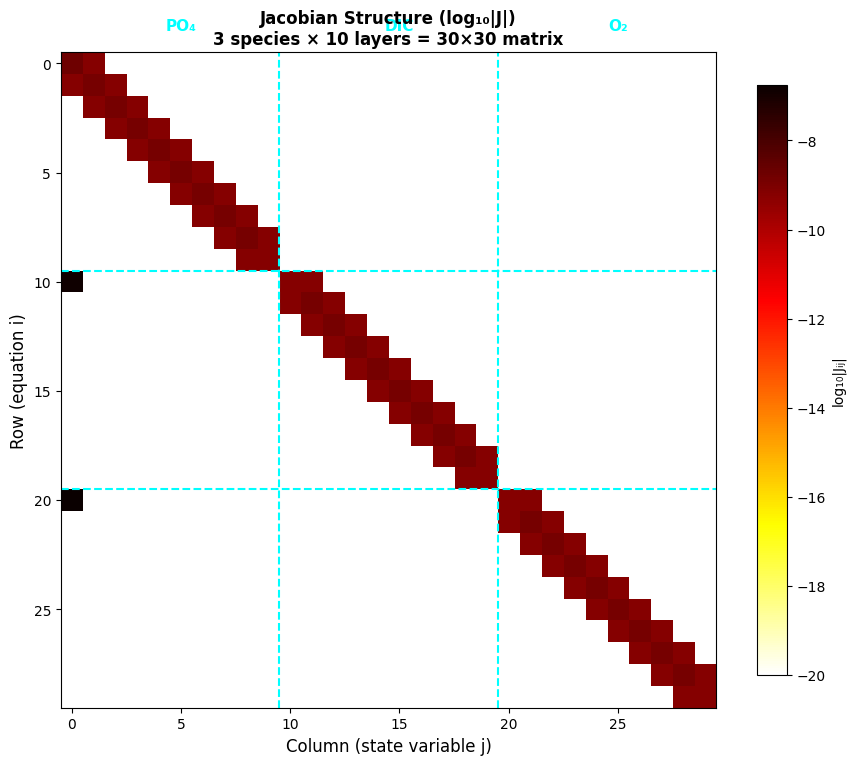

Jacobian structure reveals the physics:
  • Tridiagonal bands within each species block → DIFFUSION
  • Off-diagonal blocks (PO₄↔DIC, PO₄↔O₂) → REDFIELD COUPLING
  • Coupling only in surface layer (row/col 0) → BIOLOGICAL PUMP
  • SciPy computes this same matrix internally but never shows it to you.


In [18]:
# Visualise the Jacobian of the Chapter 8 system
# (3 species × 20 layers = 60×60 matrix)

# Simplified Chapter 8 RHS
N_lay = 10  # fewer layers for clearer visualisation
dz_v = 400.0
Kv_v = 1e-4
diff_v = Kv_v / dz_v**2
tau_bio_v = 2*365*86400

def rhs_ch8(y):
    PO4 = y[:N_lay]; DIC = y[N_lay:2*N_lay]; O2 = y[2*N_lay:]
    d = np.zeros(3*N_lay)
    dP = d[:N_lay]; dD = d[N_lay:2*N_lay]; dO = d[2*N_lay:]
    for sp, dd in [(PO4,dP),(DIC,dD),(O2,dO)]:
        for k in range(N_lay):
            if k > 0: dd[k] += diff_v*(sp[k-1]-sp[k])
            if k < N_lay-1: dd[k] += diff_v*(sp[k+1]-sp[k])
    prod = max(PO4[0],0)/(max(PO4[0],0)+0.5)/tau_bio_v
    dP[0] -= prod; dD[0] -= prod*106; dO[0] += prod*138
    return d

y_test = np.concatenate([np.full(N_lay, 2.0),
                          np.full(N_lay, 2200.0),
                          np.full(N_lay, 200.0)])

# Compute numerical Jacobian
n = len(y_test)
J = np.zeros((n, n))
f0 = rhs_ch8(y_test)
for j in range(n):
    dy = np.zeros(n)
    h = max(abs(y_test[j]) * 1e-7, 1e-12)
    dy[j] = h
    J[:, j] = (rhs_ch8(y_test + dy) - f0) / h

fig, ax = plt.subplots(figsize=(9, 8))
im = ax.imshow(np.log10(np.abs(J) + 1e-20), cmap='hot_r', aspect='equal')
ax.set_xlabel('Column (state variable j)', fontsize=12)
ax.set_ylabel('Row (equation i)', fontsize=12)
ax.set_title('Jacobian Structure (log₁₀|J|)\n'
             '3 species × 10 layers = 30×30 matrix',
             fontsize=12, fontweight='bold')

# Mark species blocks
for boundary in [N_lay, 2*N_lay]:
    ax.axhline(y=boundary-0.5, color='cyan', linewidth=1.5, linestyle='--')
    ax.axvline(x=boundary-0.5, color='cyan', linewidth=1.5, linestyle='--')

ax.text(N_lay/2, -1.5, 'PO₄', ha='center', fontsize=11, fontweight='bold', color='cyan')
ax.text(1.5*N_lay, -1.5, 'DIC', ha='center', fontsize=11, fontweight='bold', color='cyan')
ax.text(2.5*N_lay, -1.5, 'O₂', ha='center', fontsize=11, fontweight='bold', color='cyan')

plt.colorbar(im, ax=ax, label='log₁₀|Jᵢⱼ|', shrink=0.8)
plt.tight_layout()
plt.show()

print("Jacobian structure reveals the physics:")
print("  • Tridiagonal bands within each species block → DIFFUSION")
print("  • Off-diagonal blocks (PO₄↔DIC, PO₄↔O₂) → REDFIELD COUPLING")
print("  • Coupling only in surface layer (row/col 0) → BIOLOGICAL PUMP")
print("  • SciPy computes this same matrix internally but never shows it to you.")

### 3. You understand convergence

When Walker's Newton-Raphson needs 4–5 iterations instead of the usual 1–2, that tells you the problem is strongly nonlinear at that point. With SciPy, the solver may take smaller steps for the same reason, but it reports this only as a change in step size, not as "the nonlinearity got harder."

---

## 9.6 Convergence order: Seeing 1st vs 5th order

The most dramatic advantage of modern solvers: convergence order.

Walker's reverse Euler has error $O(\Delta t)$. Radau has $O(\Delta t^5)$. This means halving the step size reduces Walker's error by 2×, but Radau's by 32×!

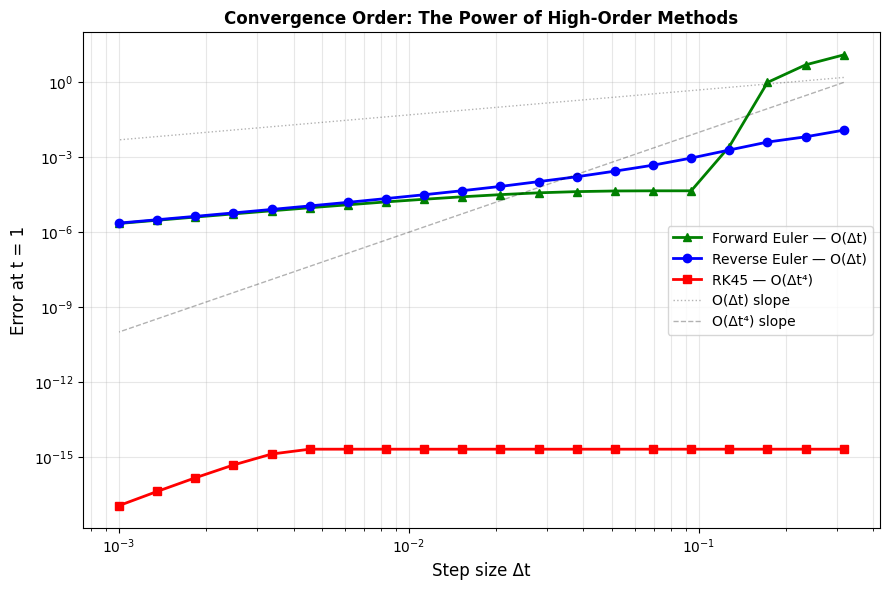

At Δt = 0.01:
  Forward Euler error: 2.09e-05
  Reverse Euler error: 3.16e-05
  RK45 error:          2.02e-15
  Ratio (Euler/RK45):  15678216533×


In [19]:
# Convergence order demonstration
# Use a problem with known exact solution: exponential decay
# dy/dt = -10*y, y(0)=1, exact: y(1) = exp(-10)

lam = -10.0
y_exact = np.exp(lam * 1.0)

dt_scan = np.logspace(-0.5, -3, 20)
err_forward = []
err_reverse = []
err_rk45 = []

for dt in dt_scan:
    n = int(1.0 / dt)
    actual_dt = 1.0 / n
    
    # Forward Euler
    y = 1.0
    for _ in range(n):
        y = y + actual_dt * lam * y
    err_forward.append(abs(y - y_exact))
    
    # Reverse Euler
    y = 1.0
    for _ in range(n):
        y = y / (1 - actual_dt * lam)
    err_reverse.append(abs(y - y_exact))

# SciPy RK45 with fixed max_step
for dt in dt_scan:
    sol = solve_ivp(lambda t, y: lam * y, (0, 1), [1.0],
                    method='RK45', max_step=dt, rtol=1e-14, atol=1e-14)
    err_rk45.append(abs(sol.y[0, -1] - y_exact))

fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(dt_scan, err_forward, 'g^-', linewidth=2, markersize=6,
          label='Forward Euler — O(Δt)')
ax.loglog(dt_scan, err_reverse, 'bo-', linewidth=2, markersize=6,
          label='Reverse Euler — O(Δt)')
ax.loglog(dt_scan, err_rk45, 'rs-', linewidth=2, markersize=6,
          label='RK45 — O(Δt⁴)')

# Reference slopes
dt_ref = np.array([dt_scan[0], dt_scan[-1]])
ax.loglog(dt_ref, 5*dt_ref, 'k:', linewidth=1, alpha=0.3, label='O(Δt) slope')
ax.loglog(dt_ref, 100*dt_ref**4, 'k--', linewidth=1, alpha=0.3, label='O(Δt⁴) slope')

ax.set_xlabel('Step size Δt', fontsize=12)
ax.set_ylabel('Error at t = 1', fontsize=12)
ax.set_title('Convergence Order: The Power of High-Order Methods',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

print("At Δt = 0.01:")
idx = np.argmin(np.abs(dt_scan - 0.01))
print(f"  Forward Euler error: {err_forward[idx]:.2e}")
print(f"  Reverse Euler error: {err_reverse[idx]:.2e}")
print(f"  RK45 error:          {err_rk45[idx]:.2e}")
print(f"  Ratio (Euler/RK45):  {err_reverse[idx]/max(err_rk45[idx],1e-16):.0f}×")

---

## 9.7 Both have their place

### Use Walker's methods when:

- **Learning** — you want to understand what implicit methods do, what the Jacobian means, why stiffness in a system is important
- **Debugging** — when a model gives wrong answers, it helps to see the Newton iterations, the Jacobian structure, the eigenvalues
- **Teaching** — Walker's entire book is pedagogical; the methods *are* the lesson
- **Prototyping** — for simple systems (2–10 equations), the overhead of learning a (SciPy) library may exceed the benefit

### Use SciPy (or equivalent) when:

- **Accuracy matters** — high-order methods give you orders of magnitude better accuracy for the same work
- **Robustness matters** — adaptive stepping handles transients, near-singularities, and stiffness changes automatically
- **Large systems** — the 60-variable Chapter 8 problem is at the edge of what's comfortable by hand; real ocean models have millions of variables
- **Publication** — reviewers expect convergence tests, error estimates, and validated solvers

### The ideal workflow:

1. **Build the model with Walker's methods** — understand the physics, see the Jacobian, verify conservation, watch convergence
2. **Switch to SciPy for production** — use Radau or BDF for stiff problems, RK45 for non-stiff, with adaptive error control
3. **Cross-validate** — confirm both approaches give the same answer (they should!)

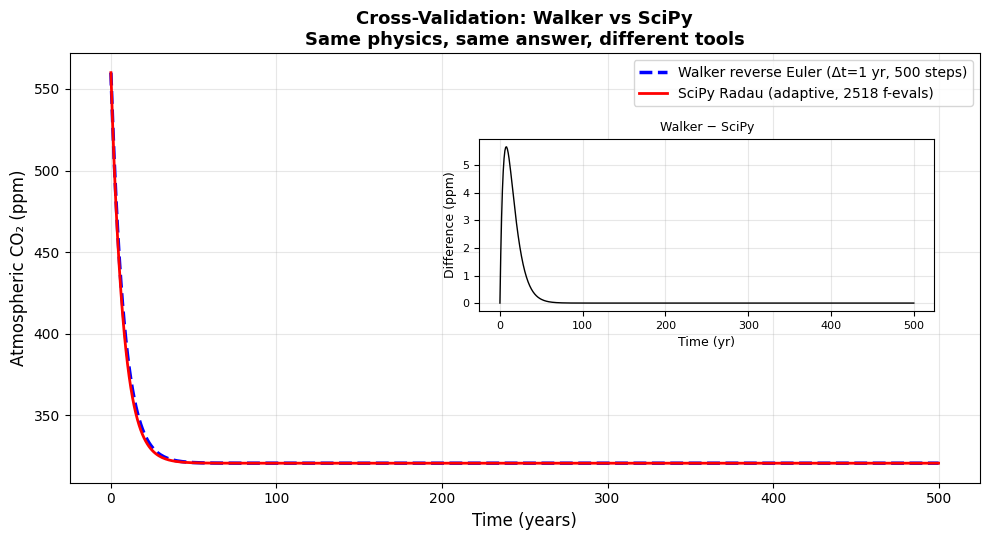

Maximum difference (Walker − SciPy): 5.667 ppm
Equilibrium (Walker):  320.727 ppm
Equilibrium (SciPy):   320.727 ppm

→ Same answer. Different roads.


In [20]:
# ============================================================
# Final cross-validation: Chapter 4 system
# ============================================================

# Walker's reverse Euler (dt = 1 yr)
t_w, y_w, _ = reverse_euler_co2(y0_co2, 1.0, 500)

# SciPy Radau
sol = solve_ivp(rhs_co2, (0, 500), y0_co2, method='Radau',
                jac=jac_co2, rtol=1e-10, atol=1e-12,
                t_eval=np.arange(0, 501, 1))

# Forward Euler (small dt = 0.01 yr, 50000 steps)
dt_fe = 0.01
n_fe = int(500 / dt_fe)
y_fe = y0_co2.copy()
t_fe_vals = [0]; y_fe_vals = [y_fe.copy()]
for _ in range(n_fe):
    y_fe = y_fe + dt_fe * rhs_co2(0, y_fe)
    if len(t_fe_vals) % 100 == 0:
        t_fe_vals.append(len(t_fe_vals) * dt_fe)
        y_fe_vals.append(y_fe.copy())

fig, ax = plt.subplots(figsize=(10, 5.5))

ax.plot(t_w, y_w[:, 0] * 280, 'b--', linewidth=2.5,
        label=f'Walker reverse Euler (Δt=1 yr, {500} steps)')
ax.plot(sol.t, sol.y[0] * 280, 'r-', linewidth=2,
        label=f'SciPy Radau (adaptive, {sol.nfev} f-evals)')

ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Atmospheric CO₂ (ppm)', fontsize=12)
ax.set_title('Cross-Validation: Walker vs SciPy\n'
             'Same physics, same answer, different tools',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Inset: difference
ax_inset = ax.inset_axes([0.45, 0.4, 0.5, 0.4])
diff_ppm = (np.interp(sol.t, t_w, y_w[:, 0]) - sol.y[0]) * 280
ax_inset.plot(sol.t, diff_ppm, 'k-', linewidth=1)
ax_inset.set_xlabel('Time (yr)', fontsize=9)
ax_inset.set_ylabel('Difference (ppm)', fontsize=9)
ax_inset.set_title('Walker − SciPy', fontsize=9)
ax_inset.grid(True, alpha=0.3)
ax_inset.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

print(f"Maximum difference (Walker − SciPy): {np.max(np.abs(diff_ppm)):.3f} ppm")
print(f"Equilibrium (Walker):  {y_w[-1, 0]*280:.3f} ppm")
print(f"Equilibrium (SciPy):   {sol.y[0, -1]*280:.3f} ppm")
print(f"\n→ Same answer. Different roads.")

---

## 9.8 Closing thoughts

Walker's book was published in 1991, when Python didn't exist yet. His insistence on building solvers from scratch was not merely a limitation of the times, it was a **pedagogical choice**. He wanted his readers to understand the numerical methods at the same depth as the geochemistry.

Thirty-five years later, the physics and geochemistry is unchanged. The ocean still buffers CO₂ the same way, the biological pump still follows Redfield ratios, and the ice-albedo feedback still threatens Snowball Earth in a hundred million years or so :). What has changed is the toolbox. The computer interested geologist or geochemist today can do both: **build a reverse Euler + Newton-Raphson solver from scratch** (because you need to understand what happens inside the black box) and **use SciPy's Radau with confidence** (because you need your results to be accurate and efficient).

Walker taught us the first skill. This chapter bridges to the second.

---

## References

- Walker, J.C.G. (1991). *Numerical Adventures with Geochemical Cycles*. Oxford University Press.
- Hairer, E. and Wanner, G. (1996). *Solving Ordinary Differential Equations II: Stiff and Differential-Algebraic Problems*. Springer. (The theoretical foundation for Radau and BDF methods.)
- Virtanen, P. et al. (2020). SciPy 1.0: fundamental algorithms for scientific computing in Python. *Nature Methods*, 17, 261–272.
- Shampine, L.F. and Reichelt, M.W. (1997). The MATLAB ODE Suite. *SIAM J. Sci. Comput.*, 18, 1–22.